In [289]:
import pandas as pd
import numpy as np
import math
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
energy = pd.read_table('./m8B0Ustar1ak0.05/budgetWaterwind.dat', delimiter = ' ')

E = KE + GPE <br>
$\zeta$ = dE/dt * 1/E

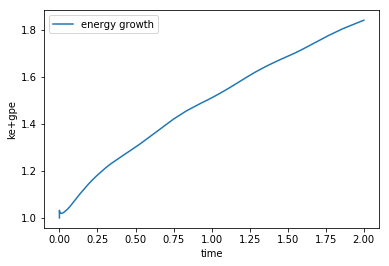

In [158]:
# plot the energy 
total = energy.ke + energy.gpe
growth_rate = np.gradient(total, energy.t) / total
plt.plot(energy.t, total/total[0])
plt.legend(['energy growth'], loc = 'upper left')
plt.xlabel('time')
plt.ylabel('ke+gpe')
plt.show()

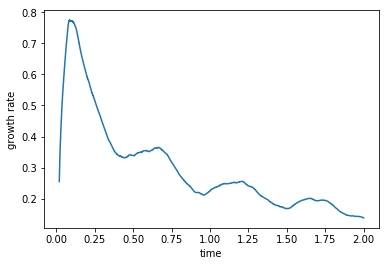

In [159]:
# plot the energy growth 
# growth_rate_hat is the smoothed growth rate curve
growth_rate_hat = savgol_filter(growth_rate, 1001, 3)
plt.plot(energy.t[1000:], growth_rate_hat[1000:])
plt.xlabel('time')
plt.ylabel('growth rate')
plt.show()

In [356]:
# Read in the field info
field = pd.read_table('./m8B0Ustar1ak0.05/field10', delimiter = ' ')


subplot: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html

In [385]:
# Take slices
# The zeroth is the table header
# If the output density is N = 512, there is 513 points per line, index 0-512 first slice, 513-(513+512) second
# Iterate from i*(N+1) to (i+1)*(N+1) (because python doesn't include the last index)
field_slice1 = field.iloc[513:1026]

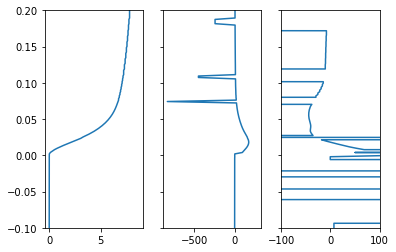

In [423]:
# An example of the noisy curvature if use directly the output
fig, axes = plt.subplots(1, 3, sharey='row')
plt.ylim(-0.1,0.2)
axes[0].plot(field_slice1['u.x'], field_slice1['y'])
axes[1].plot(field_slice1['FirOrder'], field_slice1['y'])
axes[2].plot(field_slice1['SecOrder']/field_slice1['FirOrder'], field_slice1['y'])
axes[2].set_xlim([-100, 100])
plt.show()

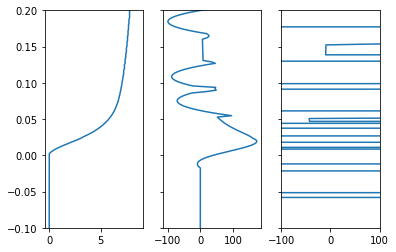

In [424]:
# Use some filter to FirOrder and SecOrder
slope_hat = savgol_filter(field_slice1['FirOrder'], 21, 3)
curvature = savgol_filter(field_slice1['SecOrder']/field_slice1['FirOrder'], 21, 3)
fig, axes = plt.subplots(1, 3, sharey='row')
plt.ylim(-0.1,0.2)
axes[0].plot(field_slice1['u.x'], field_slice1['y'])
axes[1].plot(slope_hat, field_slice1['y'])
axes[2].plot(curvature, field_slice1['y'])
axes[2].set_xlim([-100, 100])
plt.show()

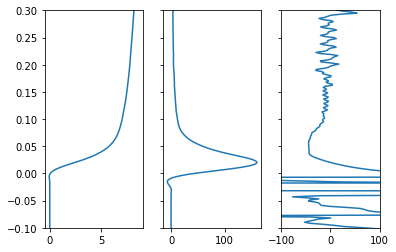

In [422]:
# Getting gradient from BASILISK output 
# v.s. Getting gradient from first interpolating then smoothening then np.gradient
# Not sure if to smooth the curve or how much to smooth
ux_hat = savgol_filter(field_slice1['u.x'], 21, 3)
# first order derivative
slope = np.gradient(ux_hat, field_slice1['y']) 
slope_hat = savgol_filter(slope, 21, 3)
# second order derivative / first order derivative = curvature
curvature = np.gradient(slope_hat, field_slice1['y']) / (slope + 0.0000001) 
fig, axes = plt.subplots(1, 3, sharey='row')
plt.ylim(-0.1,0.3)
axes[0].plot(ux_hat, field_slice1['y'])
axes[1].plot(slope_hat, field_slice1['y'])
axes[2].plot(curvature, field_slice1['y'])
axes[2].set_xlim([-100, 100])
plt.show()

In [346]:
# Transform np array curvature into pd DataFrame field_curv and the concatenate
# Not sure if should use curvature_hat or curvature
field_curv = pd.DataFrame(curvature, columns = ['curv'])
# Notice: don't run this multiple times
field = pd.concat([field, field_curv], axis=1)

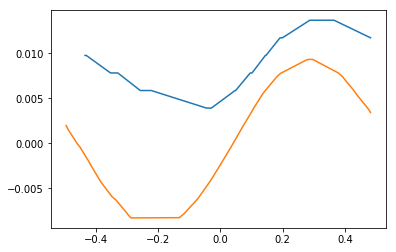

In [347]:
# Find the points at the interface
field_interface = field[field.pos != 1.000000e+30]
# define an small quantity eps, get the points with u.x close to wave speed c = 1 within the tolerance of eps 
# as field_cl (critical layer)
eps = 0.01
field_cl = field[abs((field['u.x']-1)) < eps]
# Plot the two curves 
plt.plot(field_cl.x, field_cl.y)
plt.plot(field_interface.x, field_interface.pos)
plt.show()

In [348]:
# Now let's do a correlation between 
field_cl.curv

17190     49.413494
17703     23.120789
18216     49.210261
38735     23.780909
39248     23.337328
40274     22.774075
44891     85.262279
63871     44.178104
64384     44.157423
64897     18.379492
65410     18.022305
65923     17.763513
73105     77.909132
119787   -32.677082
120300   -34.883749
121326   -38.677382
121839    -5.102916
122865    -7.102716
123378    -9.584019
123891   -11.916930
143899   -47.930925
144412   -50.631832
156725   -72.500522
158264   -93.432365
169551   -40.116208
170064   -32.981952
181864    14.452468
183916   -13.233719
207002   -43.726963
207515   -40.275933
208028   -37.797847
208541   -35.734889
223418    14.063180
223931    12.596930
224444    11.298450
224957    10.514034
225470    11.650554
225983    18.094433
226496    26.710250
227009    31.537459
227522    31.202177
258301    40.645105
Name: curv, dtype: float64

In [349]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

growth_sample = np.empty([64,1])
curv_sample = np.empty([64,1])
for i in range(0, 63): 
    t = (2*math.pi)**(.5)/32 * (i+1)
    index1 = find_nearest(energy.t, t)
    growth_sample[i,0] = growth_rate[index1]
    filename = './m8B0Ustar1ak0.05/field%d' % (i+1)
    field = pd.read_table(filename, delimiter = ' ')
    slope = np.gradient(field['u.x'], field['y']) # first order derivative
    slope_hat = savgol_filter(slope, 21, 3)
    # second order derivative / first order derivative = curvature
    curvature = np.gradient(slope_hat, field['y']) / (slope_hat + 0.0001)
    curv_aver = np.mean(curvature)
    curv_sample[i,0] = curv_aver

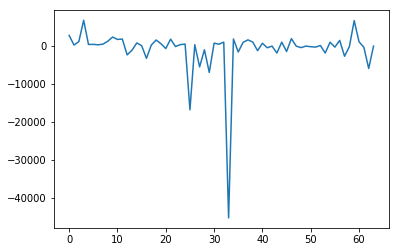

In [350]:
plt.plot(curv_sample/growth_sample)
plt.show()

In [351]:
curv_sample

array([[ 2.11497125e+03],
       [ 1.99818987e+02],
       [ 6.51208657e+02],
       [ 2.94084639e+03],
       [ 1.66550470e+02],
       [ 1.56604310e+02],
       [ 1.25974069e+02],
       [ 1.83513924e+02],
       [ 4.46392744e+02],
       [ 7.21384105e+02],
       [ 4.66875513e+02],
       [ 4.25965139e+02],
       [-5.21358120e+02],
       [-2.84342456e+02],
       [ 1.91028788e+02],
       [ 2.95267398e+01],
       [-6.28897708e+02],
       [ 5.38133071e+01],
       [ 2.79758246e+02],
       [ 1.16289097e+02],
       [-1.29720717e+02],
       [ 3.73963052e+02],
       [-2.08354706e+01],
       [ 7.65617890e+01],
       [ 8.22996782e+01],
       [-2.54921469e+03],
       [ 5.76489876e+01],
       [-8.30012067e+02],
       [-1.45600801e+02],
       [-1.05188150e+03],
       [ 1.19000858e+02],
       [ 7.74650300e+01],
       [ 1.61497411e+02],
       [-6.87916243e+03],
       [ 2.86903952e+02],
       [-2.32805560e+02],
       [ 1.52031335e+02],
       [ 2.50978958e+02],
       [ 1.6